In [2]:
# from google.colab import drive
# import shutil

# drive.mount('/content/drive')
# shutil.unpack_archive("drive/My Drive/Taxonomy Classification of AI Incidents/backup-20230925101051.tar.bz2", "/content/drive/My Drive/Taxonomy Classification of AI Incidents")

In [3]:
import pandas as pd

reports = pd.read_csv("C:/Users/34649/Desktop/UNIVERSIDAD/CUARTO/Taxonomy Classification of AI Incidents/backup-20230925101051/mongodump/reports.csv")
incidents = pd.read_csv("C:/Users/34649/Desktop/UNIVERSIDAD/CUARTO/Taxonomy Classification of AI Incidents/backup-20230925101051/mongodump/incidents.csv")


In [4]:
reports.drop(columns=["_id","incident_id","authors","date_downloaded","date_modified","date_published","date_submitted","epoch_date_downloaded","epoch_date_modified","epoch_date_published","epoch_date_submitted","image_url","language","ref_number","report_number","source_domain","submitters","url","tags"], inplace=True)

In [5]:
reports.head()

,description,text,title
0,Child and consumer advocacy groups complained ...,Child and consumer advocacy groups complained ...,Google’s YouTube Kids App Criticized for ‘Inap...
1,Parents will be able to handpick the channels ...,"YouTube Kids, which has been criticized for in...","YouTube Kids, Criticized for Content, Introduc..."
2,Children's search terms on YouTube are still a...,Video still of a reproduced version of Minnie ...,Children's YouTube is still churning out blood...
3,Investigators found several unsuitable videos ...,Google-owned YouTube has apologised again afte...,YouTube Kids app is STILL showing disturbing v...
4,YouTube removed videos from conspiracy theoris...,Children were able to watch David Icke's consp...,YouTube suggested conspiracy videos to childre...


In [6]:
print('The reports dataset contains', len(reports), 'rows')

The reports dataset contains 3028 rows


In [7]:
incidents.drop(columns=["_id","incident_id","date","Alleged deployer of AI system","Alleged developer of AI system","Alleged harmed or nearly harmed parties"], inplace=True)

In [8]:
incidents.head()

,reports,description,title
0,"[242,243,244,245,246,247,248,249,250,253,254,2...",A self-driving public shuttle by Keolis North ...,Las Vegas Self-Driving Bus Involved in Accident
1,"[629,630,631,632,633,634,635,636,637,638,639,6...",An Uber autonomous vehicle (AV) in autonomous ...,Uber AV Killed Pedestrian in Arizona
2,"[1,2,3,4,5,6,7,8,9,10,11,12,14,15]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...
3,"[130,131,132,133,134,135,136,137,138,1367,1368]",Google Image returns results that under-repres...,Gender Biases of Google Image Search
4,[42],Researchers from Boston University and Microso...,Common Biases of Vector Embeddings


In [9]:
print('The incidents dataset contains', len(incidents), 'rows')

The incidents dataset contains 556 rows


In [10]:
# Let's import the necessary libraries for NLTK preprocessing
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34649\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\34649\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\34649\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
def prepare_data(text):
# This function does the whole preparation of the data for us

    # Remove HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()

    # Remove URLs
    text = re.sub(r'https://\S+|www\.\S+', '', text)

    # Expand contractions
    text = contractions.fix(text)

    # Tokenize at sentence and word level
    review_tokens_sent = [wordpunct_tokenize(sent) for sent in sent_tokenize(text)]
    review_tokens = [token for sent in review_tokens_sent for token in sent]

    # Filter tokens
    review_tokens_filtered = [token.lower() for token in review_tokens if token.isalnum()]

    # Stem and lemmatize tokens
    wnl = WordNetLemmatizer()
    lemmatized_review = [wnl.lemmatize(token) for token in review_tokens_filtered]

    # Remove stopwords
    stopwords_en = set(stopwords.words('english'))
    clean_review = [token for token in lemmatized_review if token not in stopwords_en]

    return clean_review

In [12]:
# We use the function above to create a clean review column of the prepared data
incidents['clean_review'] = incidents['description'].apply(prepare_data)

#Let's visualize the new column 'clean_review'
incidents.head(1)

C:\Users\34649\AppData\Local\Temp\ipykernel_15904\3342570128.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


,reports,description,title,clean_review
0,"[242,243,244,245,246,247,248,249,250,253,254,2...",A self-driving public shuttle by Keolis North ...,Las Vegas Self-Driving Bus Involved in Accident,"[self, driving, public, shuttle, keolis, north..."


In [13]:
# We use the function above to create a clean review column of the prepared data
reports['clean_review'] = reports['text'].apply(prepare_data)

#Let's visualize the new column 'clean_review'
reports.head(1)

C:\Users\34649\AppData\Local\Temp\ipykernel_15904\3342570128.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


,description,text,title,clean_review
0,Child and consumer advocacy groups complained ...,Child and consumer advocacy groups complained ...,Google’s YouTube Kids App Criticized for ‘Inap...,"[child, consumer, advocacy, group, complained,..."


In [14]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_clean_review(data):
    # Create a new DataFrame where each word is in a separate row
    words = data.explode("clean_review")

    # Flatten nested lists of strings
    words = words.apply(lambda x: [y if isinstance(y, str) else "" for y in x])

    # Count the frequency of each word
    word_counts = Counter(words["clean_review"].tolist())

    # Create a word cloud
    wc = WordCloud(background_color="white", width=800, height=400,
                   max_words=200, colormap="viridis").generate_from_frequencies(word_counts)

    # Visualize the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

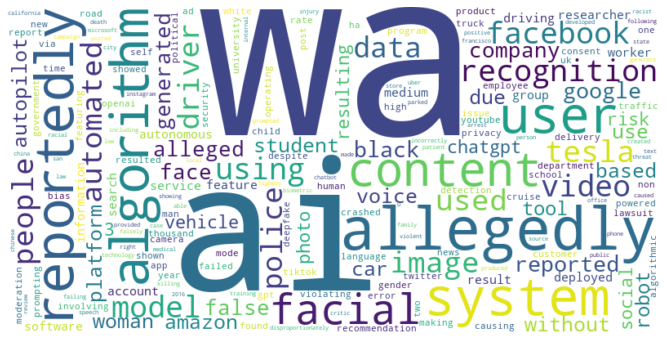

In [15]:
visualize_clean_review(incidents)

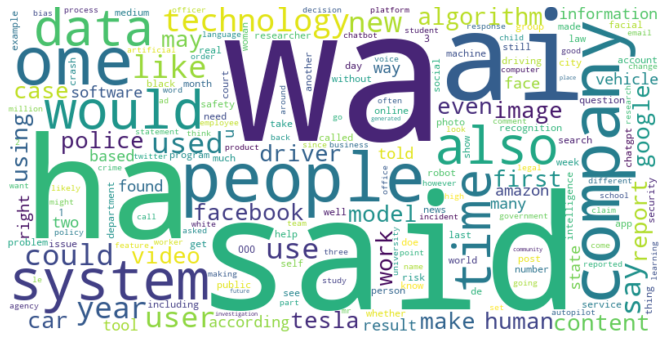

In [16]:
visualize_clean_review(reports)

In [17]:
from termcolor import colored

corpus = []
for review in reports['clean_review']:
  corpus.append(review)

print(colored('Number of documents in corpus: '+str(len(corpus)), 'green'))
print(colored('\n============= First review =============', 'blue'))
print(corpus[0])

Number of documents in corpus: 3028

============= First review =============
['child', 'consumer', 'advocacy', 'group', 'complained', 'federal', 'trade', 'commission', 'tuesday', 'google', 'new', 'youtube', 'kid', 'app', 'contains', 'inappropriate', 'content', 'including', 'explicit', 'sexual', 'language', 'joke', 'pedophilia', 'google', 'launched', 'app', 'young', 'child', 'february', 'saying', 'available', 'video', 'narrowed', 'content', 'appropriate', 'kid']


In [18]:
import numpy as np

# Calculate the average number of tokens per review
avg_tokens_per_review = np.mean([len(review) for review in corpus])
print(f"Average number of tokens per review: {avg_tokens_per_review:.2f}")

Average number of tokens per review: 454.84


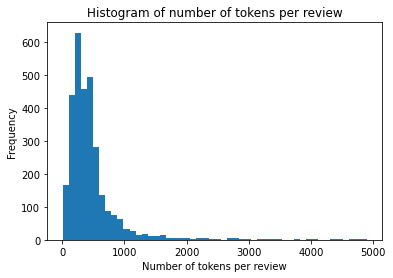

In [19]:
# Plot the histogram of the number of tokens per review
plt.hist([len(review) for review in corpus], bins=50)
plt.xlabel("Number of tokens per review")
plt.ylabel("Frequency")
plt.title("Histogram of number of tokens per review")
plt.show()

In [20]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

print(colored('\n============= First review in corpus =============', 'blue'))
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print(colored('\n============= First review after N-gram replacement =============', 'blue'))
print(corpus[0])


============= First review in corpus =============
['child', 'consumer', 'advocacy', 'group', 'complained', 'federal', 'trade', 'commission', 'tuesday', 'google', 'new', 'youtube', 'kid', 'app', 'contains', 'inappropriate', 'content', 'including', 'explicit', 'sexual', 'language', 'joke', 'pedophilia', 'google', 'launched', 'app', 'young', 'child', 'february', 'saying', 'available', 'video', 'narrowed', 'content', 'appropriate', 'kid']

============= First review after N-gram replacement =============
['child', 'consumer_advocacy', 'group', 'complained', 'federal_trade', 'commission', 'tuesday', 'google', 'new', 'youtube_kid', 'app', 'contains', 'inappropriate_content', 'including', 'explicit_sexual', 'language', 'joke', 'pedophilia', 'google', 'launched', 'app', 'young_child', 'february', 'saying', 'available', 'video', 'narrowed', 'content', 'appropriate', 'kid']


In [21]:
# We will now save the fully processed corpus into a text file
reports['clean_review'] = corpus

with open("lemmas_clean.txt", 'w', encoding='utf-8') as fout:
  for el in reports['clean_review'].values.tolist():
    fout.write(' '.join(el) + '\n')

In [22]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 66720 terms
First terms in the dictionary:
0 : app
1 : appropriate
2 : available
3 : child
4 : commission
5 : complained
6 : consumer_advocacy
7 : contains
8 : content
9 : explicit_sexual


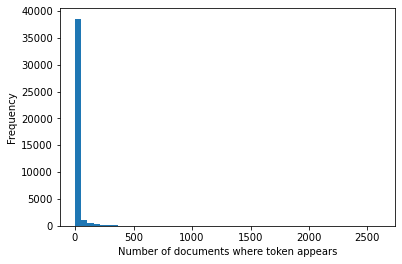

             token  token_id  ndocs
0           people        74   2604
1               11        28   2390
2           animal       126   2049
3             also        33   2005
4             lack        60   1917
...            ...       ...    ...
41064       starry     28687      2
41065          cận     61855      2
41066      flatten     61807      2
41067        cầyou     61854      2
41068  campaigning     35867      2

[41069 rows x 3 columns]


In [23]:
# We create the dataframe
token_counts = pd.DataFrame(D.token2id.items(), columns=['token', 'token_id'])
token_counts['ndocs'] = D.dfs.values()

# We sort in descending order
token_counts = token_counts.sort_values('ndocs', ascending=False).reset_index(drop=True)

# We discard tokens that appear in just one doc
token_counts = token_counts[token_counts.ndocs > 1]

# Define most and least common tokens
most_common_tokens = token_counts.head()
less_common_tokens = token_counts.tail()

# PLot the histogram
plt.hist(token_counts['ndocs'], bins=50)
plt.xlabel('Number of documents where token appears')
plt.ylabel('Frequency')
plt.show()

print(token_counts)

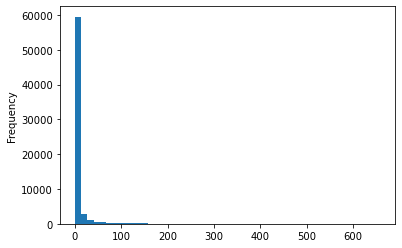

In [24]:
token_ndocs = pd.DataFrame({
    'token': [D[id] for id in range(n_tokens)],
    'ndocs': [D.dfs[id] for id in range(n_tokens)]
})

token_ndocs = token_ndocs.sort_values(by='ndocs', ascending=False)

unique_ndocs = token_ndocs['ndocs'].value_counts()
one_doc_tokens = unique_ndocs[unique_ndocs == 1].index
token_ndocs = token_ndocs[~token_ndocs['ndocs'].isin(one_doc_tokens)]

most_common = token_ndocs.iloc[0]['token']
least_common = token_ndocs.iloc[-1]['token']

# Plot
token_ndocs['ndocs'].plot(kind='hist', bins=50)
plt.show()

In [25]:
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 23563 terms


In [26]:
print('The original dictionary contains', len(Dictionary(corpus)), 'terms') # length of original dictionary
print('The new dictionary contains', n_tokens, 'terms') # length of new filtered dictionary

The original dictionary contains 66720 terms
The new dictionary contains 23563 terms


In [27]:
reviews_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 1000
print(colored('============= Review (lemmas) =============', 'blue'))
print(' '.join(corpus[n_review]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(reviews_bow[n_review])

print(colored('\n============= Word counts for the review =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))

============= Review (lemmas) =============
turnbull_government robo_debt program involves enforcement illegal debt case inflated nonexistent former member administrative_appeal tribunal ha said scathing indictment program contained academic_paper prof terry carney also accuses centrelink failing defend legality debt aat suggests tribunal set_aside debt agency ha proved amount correct criticism ha echoed national social security right network welfare right centre warned case false debt routinely challenged reduced completely wiped tribunal centrelink forced wipe change one six robo_debt read carney explained robo_debt program calculates welfare_recipient income average fortnightly_period rather discovering actual income every fortnightly_period writes proper basis calculating_debt carney said centrelink asks payment alleged_debt evidence disprove vulnerable alleged debtor simply throw hand assume centrelink know really debt seek pay quickly_possible said welfare_agency even_though repo

In [28]:
from gensim.models import TfidfModel

tfidf = TfidfModel(reviews_bow)

In [29]:
reviews_tfidf = tfidf[reviews_bow]
n_project = 1000
print(colored('============= TFIDF representation for the project =============', 'blue'))
print(reviews_tfidf[n_review])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(31, 0.02668671380487424), (33, 0.008694826936258263), (50, 0.01125076628847279), (74, 0.005808428120728336), (78, 0.015700137867965078), (81, 0.0282659556296365), (82, 0.04188911098755316), (85, 0.035285216421866966), (89, 0.015330926622239447), (98, 0.015676835602513924), (103, 0.008613957710413457), (109, 0.0215825303382989), (132, 0.039820581889417866), (181, 0.01779771400892317), (182, 0.013348405279545063), (185, 0.02443045275204255), (192, 0.02316569341175866), (193, 0.010641350073305654), (235, 0.017988817546779827), (244, 0.015394116278437056), (253, 0.00742827632822352), (254, 0.014373135881472076), (263, 0.018540232098186955), (265, 0.03479663322810999), (291, 0.011697975581742502), (292, 0.027506295129178154), (297, 0.02043881046444175), (306, 0.011453979833116605), (310, 0.04910845802082228), (311, 0.02679122044192612), (333, 0.0076329794662457805), (334, 0.0278458869782311), (349, 0.03300470766927564), (371

In [30]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename, encoding='utf-8'):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()

MyIterCorpus = IterableCorpus_fromfile('lemmas_clean.txt')
newD = Dictionary(MyIterCorpus)
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)

print('Number of documents processed:', newD.num_docs)
print('Number of elements in dictionary:', len(newD))

Number of documents processed: 3028
Number of elements in dictionary: 23563


#######################################

In [42]:
from gensim.models import LsiModel

# Initialize an LSI transformation
n_topics = 5

lsi = LsiModel(reviews_tfidf, id2word=D, num_topics=n_topics)


In [43]:
#Display all topics including 10 most relevant tokens per topic
lsi.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.214*"tesla" + 0.144*"car" + 0.140*"ai" + 0.138*"driver" + 0.118*"google" + 0.111*"vehicle" + 0.104*"chatgpt" + 0.097*"crash" + 0.094*"facebook" + 0.092*"said"'),
 (1,
  '0.526*"tesla" + 0.268*"driver" + 0.262*"car" + 0.230*"autopilot" + 0.219*"vehicle" + 0.210*"crash" + -0.130*"ai" + 0.125*"self_driving" + -0.121*"chatgpt" + 0.101*"driving"'),
 (2,
  '-0.495*"chatgpt" + -0.233*"chatbot" + -0.201*"tessa" + 0.199*"facebook" + -0.180*"ai" + -0.166*"neda" + -0.162*"eating_disorder" + -0.150*"tesla" + -0.147*"schwartz" + -0.143*"openai"'),
 (3,
  '0.382*"tessa" + 0.323*"robot" + 0.311*"neda" + 0.311*"eating_disorder" + -0.247*"chatgpt" + 0.162*"amazon" + 0.145*"chatbot" + 0.140*"helpline" + -0.100*"google" + -0.100*"tesla"'),
 (4,
  '-0.436*"facebook" + -0.236*"ad" + 0.233*"robot" + 0.192*"amazon" + -0.175*"tessa" + -0.173*"tesla" + -0.151*"eating_disorder" + 0.148*"chatgpt" + 0.144*"shotspotter" + -0.144*"neda"')]

In [44]:
lsi.show_topic(3, topn=10)

[('tessa', 0.3822135473887306),
 ('robot', 0.3225724890365132),
 ('neda', 0.3112346725751569),
 ('eating_disorder', 0.3105798938953961),
 ('chatgpt', -0.24716158803311947),
 ('amazon', 0.1619216658178781),
 ('chatbot', 0.14517873295829872),
 ('helpline', 0.140083792142951),
 ('google', -0.09982814326420274),
 ('tesla', -0.09970133627576931)]

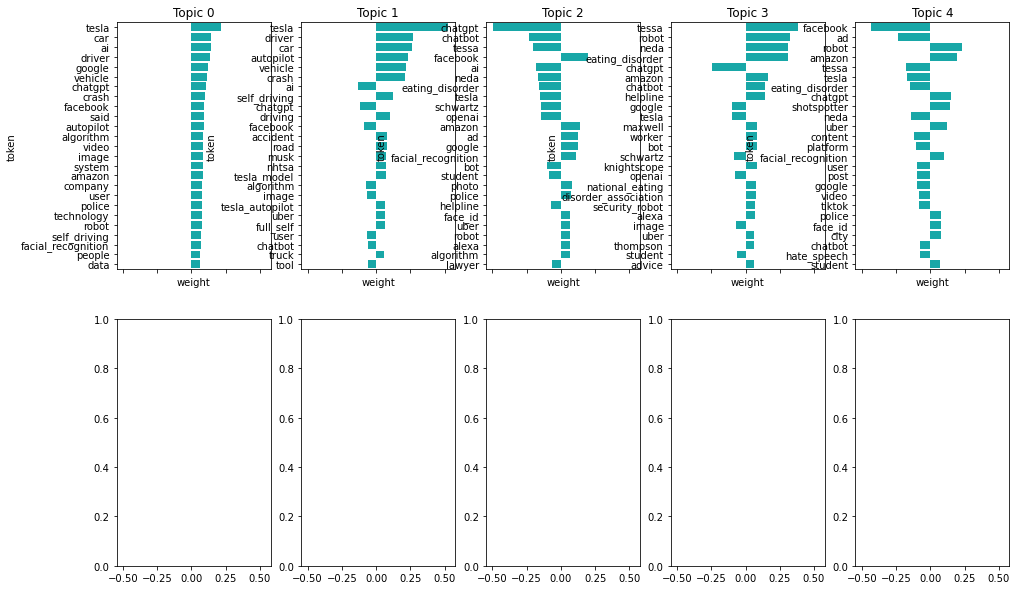

In [50]:
import seaborn as sns

topn = 25

fig, axes = plt.subplots(2, 5, figsize=(16, 10), sharex=True)

for i in range(5):


    df = pd.DataFrame(lsi.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 4


plt.show()

In [ ]:
# Assign labels to topics based on top tokens
topic_labels = {
    0: '1',
    1: '2',
    2: '3',
    3: '4',
    4: '5',
    5: '6',
    6: '7',
    7: '8',
    8: '9',
    9: '10'
}

# Display topic labels
for topic_num, label in topic_labels.items():
    print(f"Topic {topic_num}: {label}")

Topic 0: 1
Topic 1: 2
Topic 2: 3
Topic 3: 4
Topic 4: 5
Topic 5: 6
Topic 6: 7
Topic 7: 8
Topic 8: 9
Topic 9: 10


In [ ]:
corpus_lsi = lsi[reviews_tfidf]
print(corpus_lsi[0])

[(0, 0.08442855752530272), (1, -0.04018171139259399), (2, -0.05002111620773107), (3, -0.011710326430908661), (4, -0.04948068149760224), (5, -0.09125403931736994), (6, 0.031459179823525495), (7, 0.027616162231848013), (8, 0.021457147436786502), (9, -0.00999722838362031)]


In [ ]:
from gensim import matutils
selected_topic = 7
lsi_dense = matutils.corpus2dense(corpus_lsi, num_terms=n_topics, num_docs=len(corpus_lsi))

#Pick one of the following according to the whether the topic is characterized by positive or negative weights
#selected_doc = np.argmin(lsi_dense[selected_topic,:])
selected_doc = np.argmax(lsi_dense[selected_topic,:])


print('Position of selected document:', selected_doc)
print('Weight of selected document for the topic:', lsi_dense[selected_topic, selected_doc])
print(colored('\n============= Text (lemmas) of most relevant document =============', 'blue'))
print(corpus[selected_doc])


Position of selected document: 1124
Weight of selected document for the topic: 0.31671175

============= Text (lemmas) of most relevant document =============
['day', 'age', 'climate_change', 'denying', 'president', 'lack', 'healthcare', 'anti', 'vaxxers', 'easy', 'get', 'downtrodden', 'world', 'one', 'robot', 'thing', 'got', 'bit', 'much', 'appears', 'thrown', 'fountain', 'somber', 'act', 'robot', 'suicide', 'robot', 'wa', 'knightscope_k5', 'employed', 'security_robot', 'communication', 'agency', 'gmmb', 'washington_dc', 'robot', 'equipped', 'camera', 'provide', 'physical_presence', 'regular', 'security_camera', 'also', 'designed', 'move_autonomously', 'seems', 'robot', 'ended_fountain', 'post', 'twitter', 'documented', 'final_moment', 'k5_robot', 'ended', 'face', 'watery_grave', 'rip', 'k5', 'barely', 'knew', 'ye', 'maybe', 'wa', 'baptized', 'company', 'website', 'highlight', 'key', 'feature', 'robot', 'include', 'forensic', 'capability', 'recording', 'license_plate', 'something', 'w

In [ ]:
##############################################################################################

In [53]:
for i in incidents["description"]:
    print(i+ "\n")

A self-driving public shuttle by Keolis North America and Navya was involved in a collision with a human-driven delivery truck in Las Vegas, Nevada on its first day of service.

An Uber autonomous vehicle (AV) in autonomous mode struck and killed a pedestrian in Tempe, Arizona.

YouTube’s content filtering and recommendation algorithms exposed children to disturbing and inappropriate videos.

Google Image returns results that under-represent women in leadership roles, notably with the first photo of a female "CEO" being a Barbie doll after 11 rows of male CEOs.

Researchers from Boston University and Microsoft Research, New England demonstrated gender bias in the most common techniques used to embed words for natural language processing (NLP).

Amazon's book store "cataloging error" led to books containing gay and lesbian themes to lose their sales ranking, therefore losing visibility on the sales platform.

Wikipedia bots meant to remove vandalism clash with each other and form feedba